In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import plotting_utils as pu
import sa_city_utils as sacu

from utils import roar_data_path as project_data_path
from utils import gev_metric_ids, trend_metric_ids
from utils import city_list

In [2]:
# Set fonts
from matplotlib import font_manager
font_dirs = ["/storage/home/dcl5300/fonts"]

font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.5

### Testing

In [4]:
import numpy as np
import jax.numpy as jnp
from scipy.optimize import minimize
from jax.scipy import optimize 
import jax

## Useful plotting functions

In [3]:
def plot_city_metrics(city, metric_ids, plot_col, hist_slice, proj_slice, fit_method, stationary, limits=None, store=True, legend=0, read_samples=True):
    # Make axes
    fig, axs = plt.subplots(2, len(metric_ids), height_ratios=[4, 1], figsize=(4*len(metric_ids),11))
    time_str = f"{proj_slice} relative to {hist_slice}" if "diff" in plot_col else f"{proj_slice}"
    fig.suptitle(f"{pu.city_names[city]} ({time_str})", fontweight='bold')

    # Loop through examples
    for idx, metric_id in enumerate(metric_ids):
        axs_subset = axs[:,idx]

        pu.plot_city_results(
            city = city,
            metric_id = metric_id,
            plot_col = plot_col,
            hist_slice = hist_slice,
            proj_slice = proj_slice,
            fit_method = fit_method,
            stationary = stationary,
            axs = axs_subset,
            read_samples = read_samples,
            limits = limits[idx] if type(limits) == list else None,
            yticklabels = True if idx == 0 else False,
            legend = True if idx == legend else False,
        )

    plt.tight_layout()
    
    if store:
        plt.savefig(f'../figs/{city}_{plot_col}_{fit_method}_{stationary}_{hist_slice}_{proj_slice}.pdf')
    else:
        plt.show()

## Plots

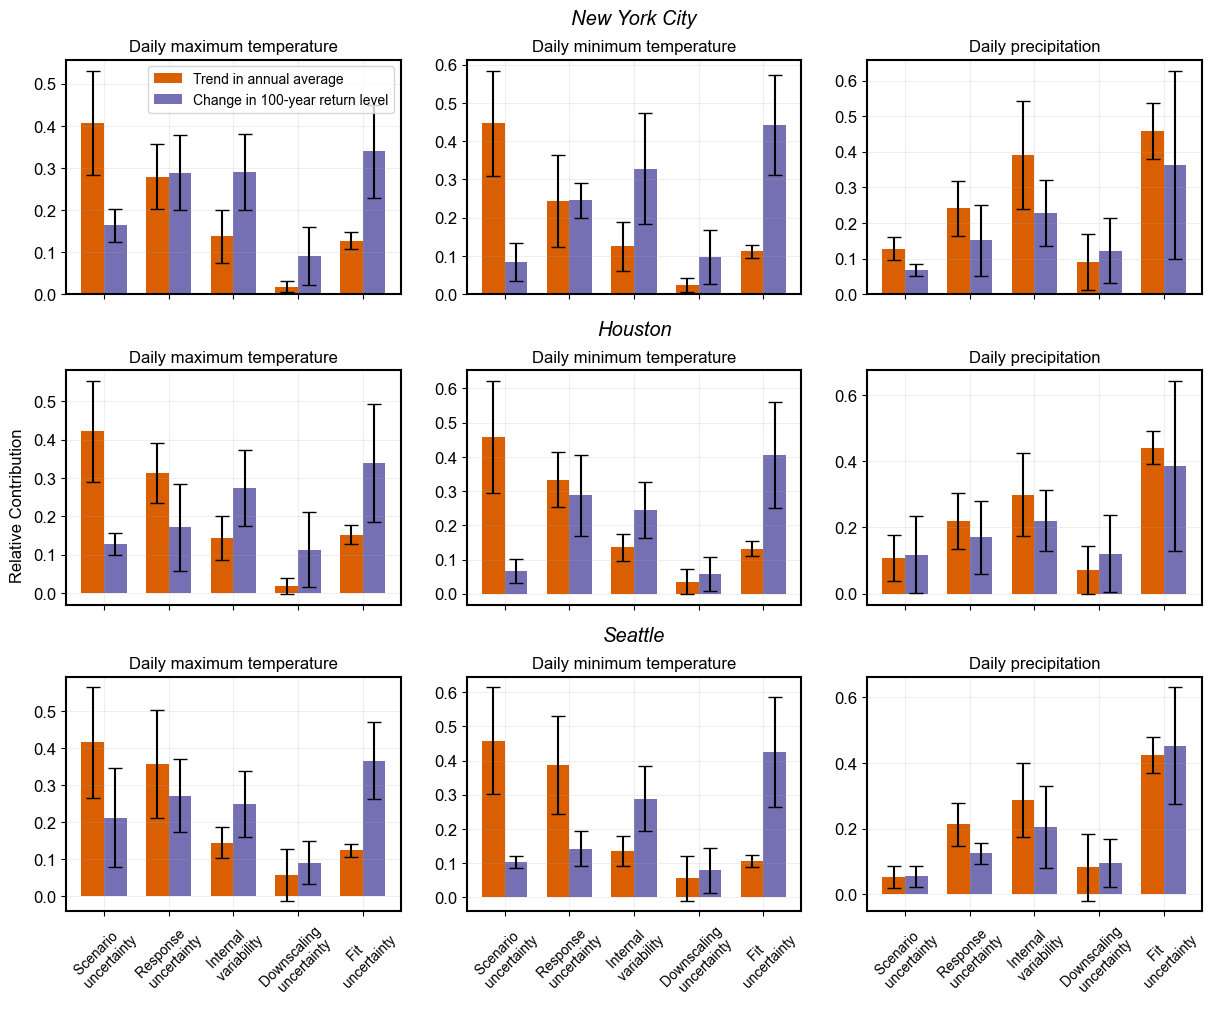

In [35]:
# Main plot
n_boot = 1000
sample_str = "_samples"
# GEV
stationary = 'stat'
fit_method = 'lmom'
proj_slice = '2050-2100'
hist_slice = '1950-2014'
# Trend
trend_years = "2015-2100"

# Combined
cities = ['nyc', 'houston', 'seattle']
trend_metric_ids = ['avg_tasmax', 'avg_tasmin', 'sum_pr']
gev_metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr']

metric_titles = {'tasmax': 'Daily maximum temperature', 
                 'tasmin': 'Daily minimum temperature', 
                 'pr': 'Daily precipitation'}

trend_label = "Trend in annual average"
gev_label = "Change in 100-year return level"

# Make figure
fig = plt.figure(figsize=(12, 10), layout='compressed')
gs = fig.add_gridspec(3, 3, hspace=0.05)

# Loop through cities
for idc, city in enumerate(cities):
    # Create city title
    ax_title = fig.add_subplot(gs[idc, :], frameon=False)
    ax_title.set_title(pu.city_names[city], fontstyle='italic', y=1.15, pad=0)
    ax_title.set_xticks([])
    ax_title.set_yticks([])

    # Loop through metrics
    for idm, (trend_metric_id, gev_metric_id) in enumerate(zip(trend_metric_ids, gev_metric_ids)):
        # Make axis
        ax = plt.subplot(gs[idc, idm])
        # Get variable
        assert trend_metric_id.split('_')[1] == gev_metric_id.split('_')[1], "variables are different"
        var_id = trend_metric_id.split('_')[1]
        
        # Read both datasets
        df_gev = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{gev_metric_id}_{hist_slice}_{proj_slice}_{fit_method}_{stationary}_nboot{n_boot}{sample_str}.csv")
        df_gev_uc = sacu.calculate_df_uc(df_gev, '100yr_return_level_diff').set_index('uncertainty_type')
        
        df_trend = pd.read_csv(f"{project_data_path}/trends/cities/original_grid/{city}_{trend_metric_id}_{trend_years}_nboot{n_boot}{sample_str}.csv")
        df_trend_uc = sacu.calculate_df_uc(df_trend, 'slope').set_index('uncertainty_type')
        
        # Plot
        pu.plot_uc_bar(df_trend_uc = df_trend_uc, 
                       df_gev_uc = df_gev_uc, 
                       ax = ax, 
                       legend=(idc==0 and idm==0), 
                       trend_label = trend_label,
                       gev_label = gev_label
                      )
        
        # Add metric title to each subplot
        ax.set_title(metric_titles[var_id], fontsize=12)
        
        # Only show x-labels on bottom row
        if idc < 2:
            ax.set_xticklabels([])

# Add global y-label
fig.supylabel('Relative Contribution', fontsize=12)

# plt.tight_layout()
plt.savefig('../figs/main/figure4.pdf', bbox_inches='tight')

In [26]:
# Robustness checks
city = 'chicago'
metric_id = 'min_tasmin'

df_stat_nboot100 = pd.read_csv(
    f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_1950-2014_2050-2100_lmom_stat_nboot100.csv"
)

df_stat_nboot1000 = pd.read_csv(
    f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_1950-2014_2050-2100_lmom_stat_nboot1000.csv"
)

df_nonstat = pd.read_csv(
    f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_1950-2100_mle_nonstat_nboot250.csv"
)

<Axes: xlabel='uncertainty_type'>

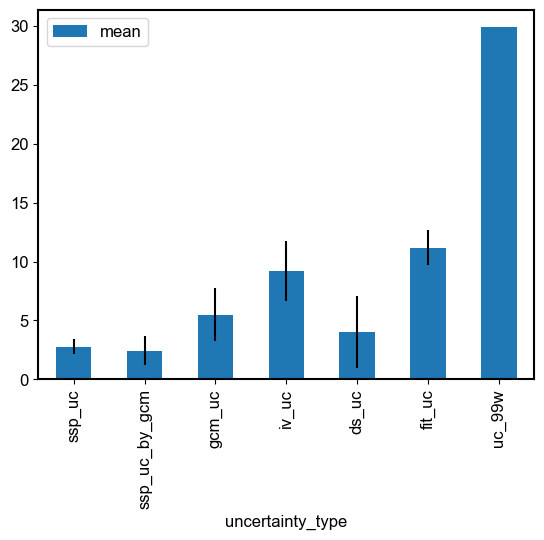

In [134]:
sacu.calculate_df_uc(df_nonstat, '100yr_return_level_diff_2075-1975').plot.bar(x="uncertainty_type", y="mean", yerr="std")

<Axes: xlabel='uncertainty_type'>

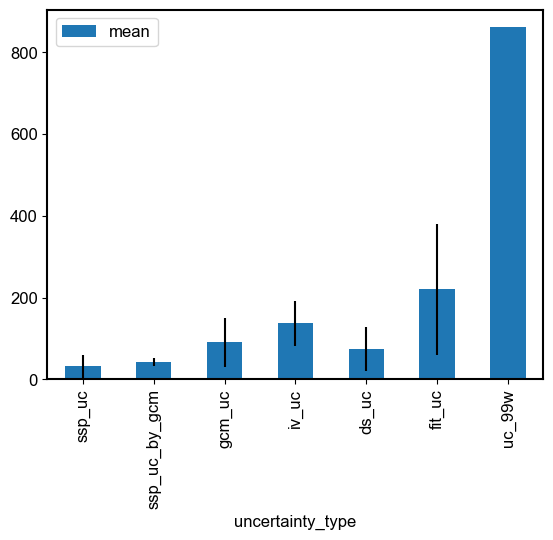

In [135]:
sacu.calculate_df_uc(df_stat_nboot1000, '100yr_return_level_diff').plot.bar(x="uncertainty_type", y="mean", yerr="std")

### Other

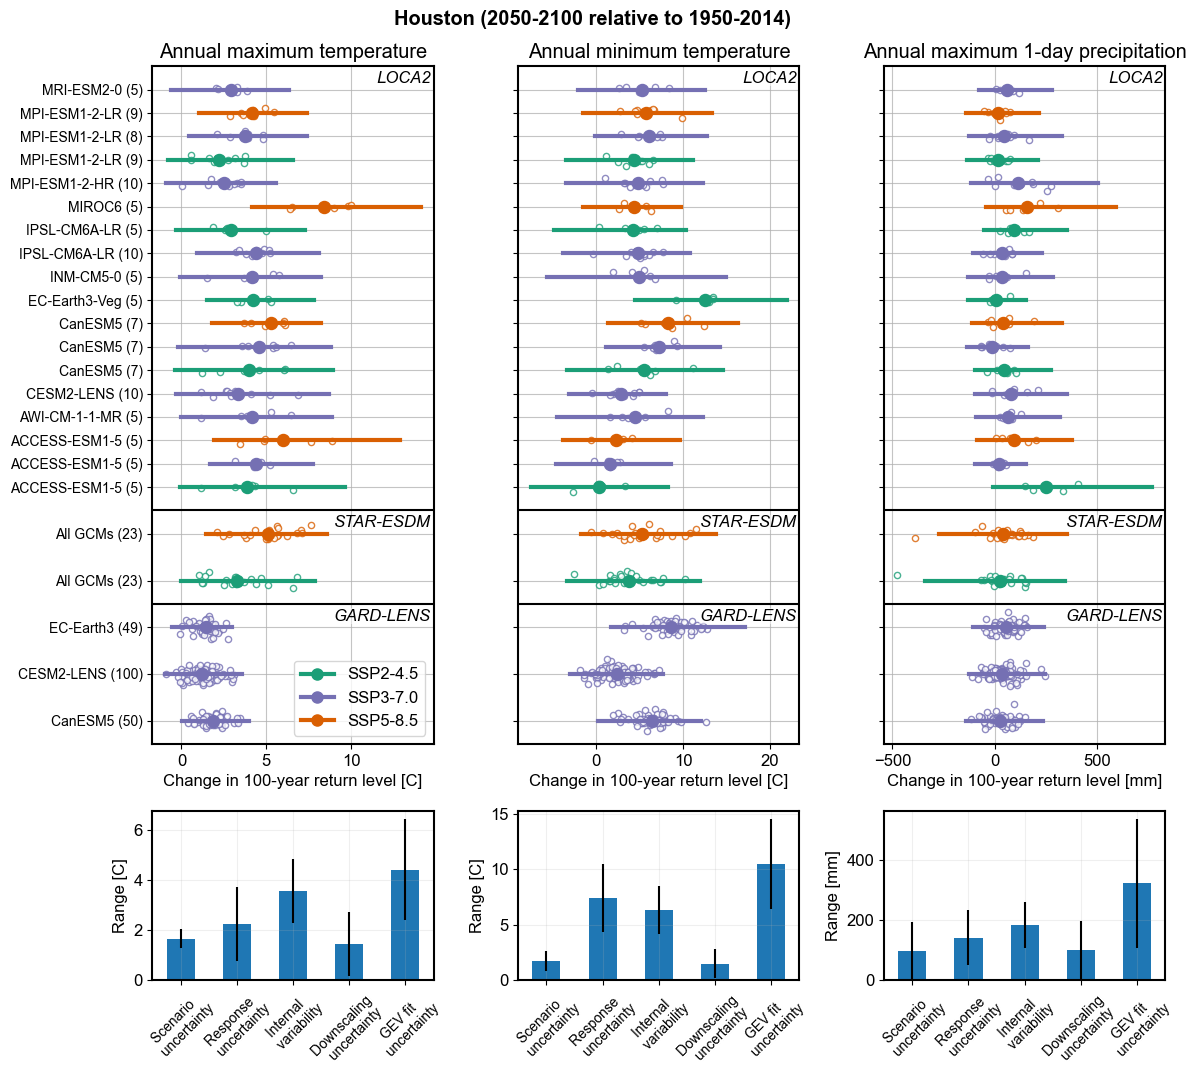

In [24]:
city = 'houston'
plot_col = '100yr_return_level_diff'
hist_slice = '1950-2014'
proj_slice = '2050-2100'
fit_method = 'lmom'
stationary = 'stat'

metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr']

plot_city_metrics(city, metric_ids, plot_col, hist_slice, proj_slice, fit_method, stationary, read_samples=True)

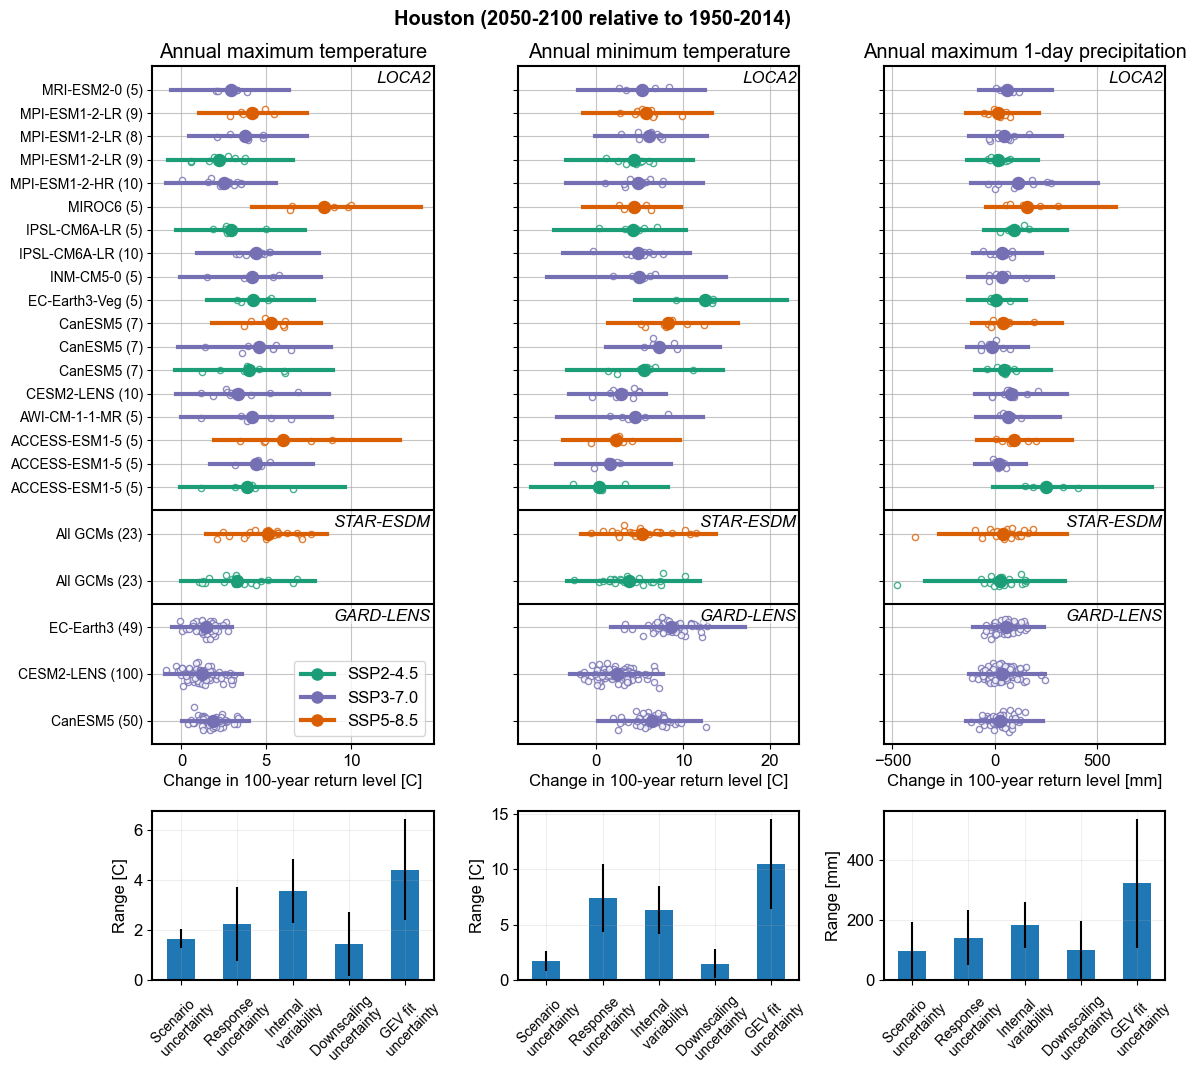

In [5]:
city = 'houston'
plot_col = '100yr_return_level_diff'
hist_slice = '1950-2014'
proj_slice = '2050-2100'
fit_method = 'lmom'
stationary = 'stat'

metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr']

plot_city_metrics(city, metric_ids, plot_col, hist_slice, proj_slice, fit_method, stationary)

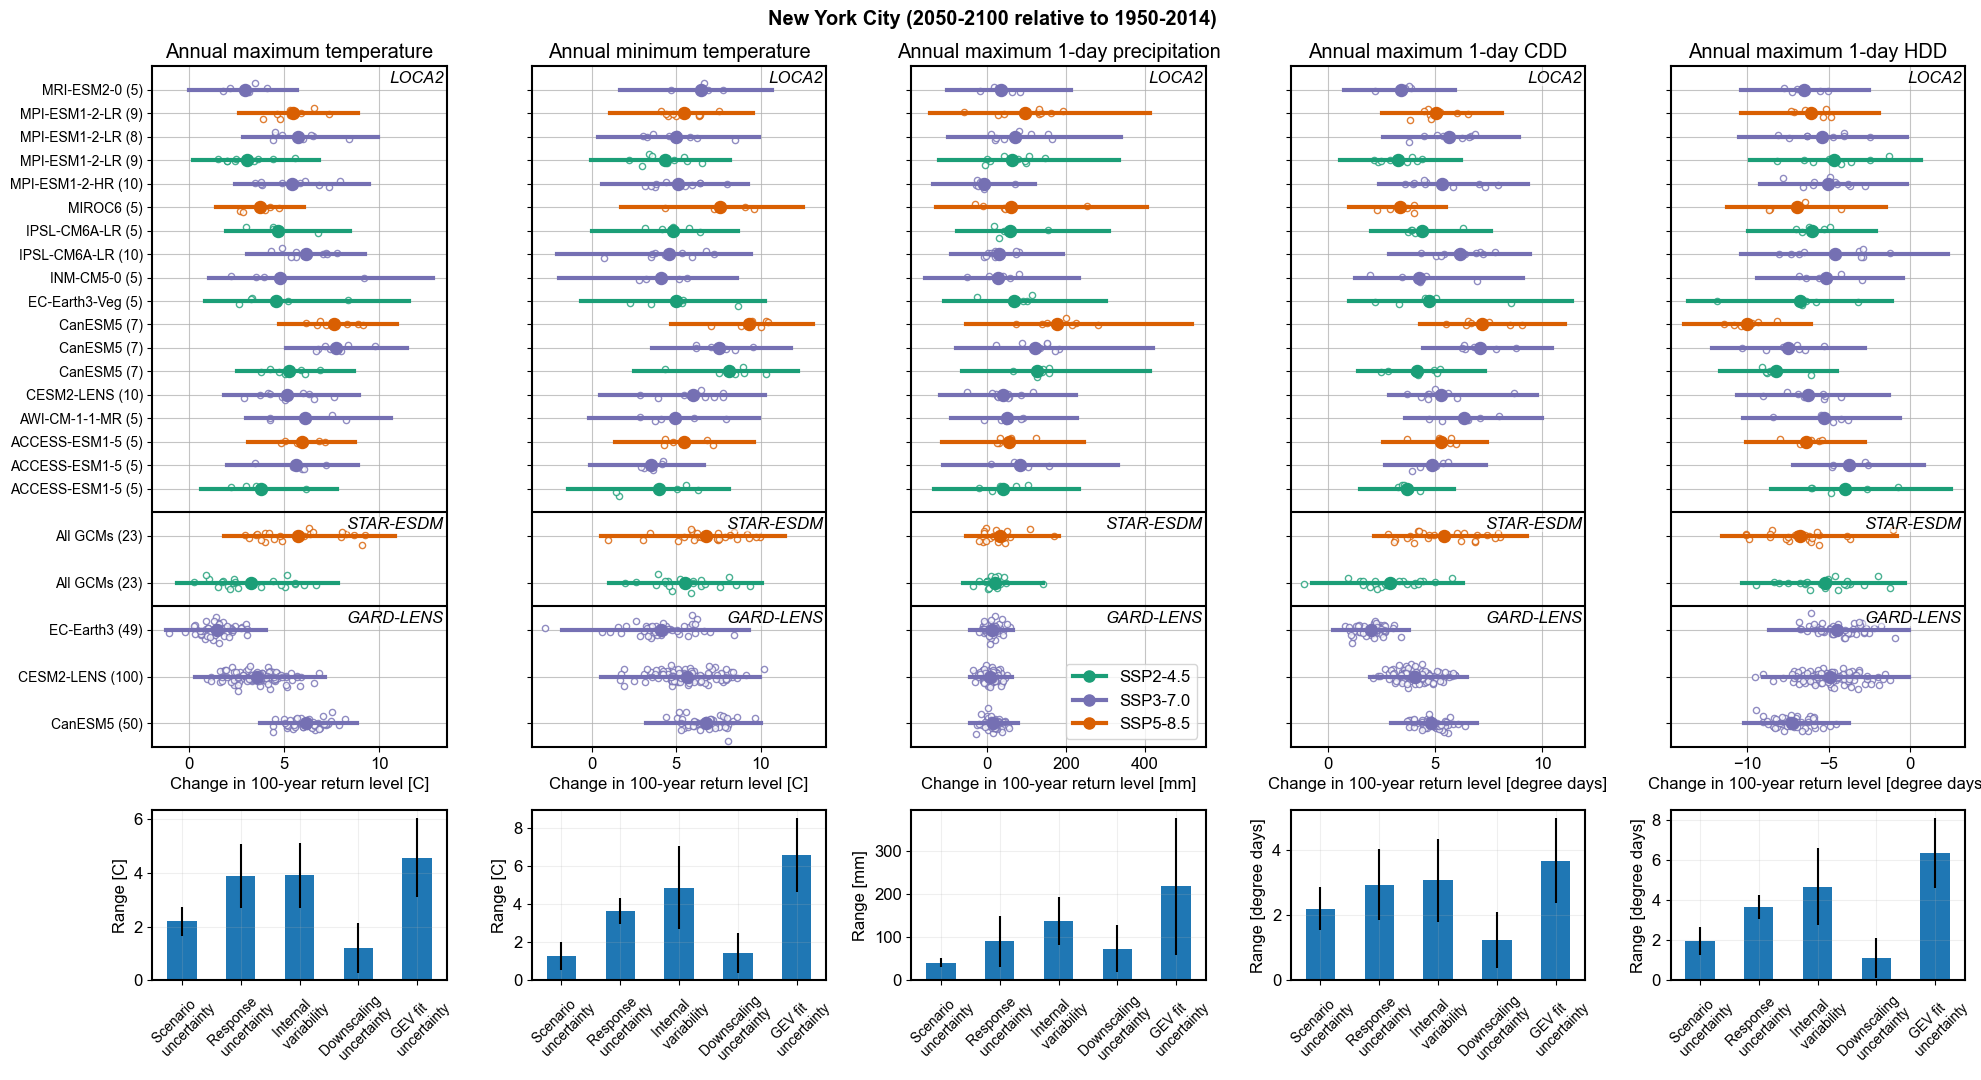

In [8]:
city = 'nyc'
plot_col = '100yr_return_level_diff'
hist_slice = '1950-2014'
proj_slice = '2050-2100'
fit_method = 'lmom'
stationary = 'stat'

metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr', 'max_cdd', 'max_hdd']

plot_city_metrics(city, metric_ids, plot_col, hist_slice, proj_slice, fit_method, stationary, legend=2)

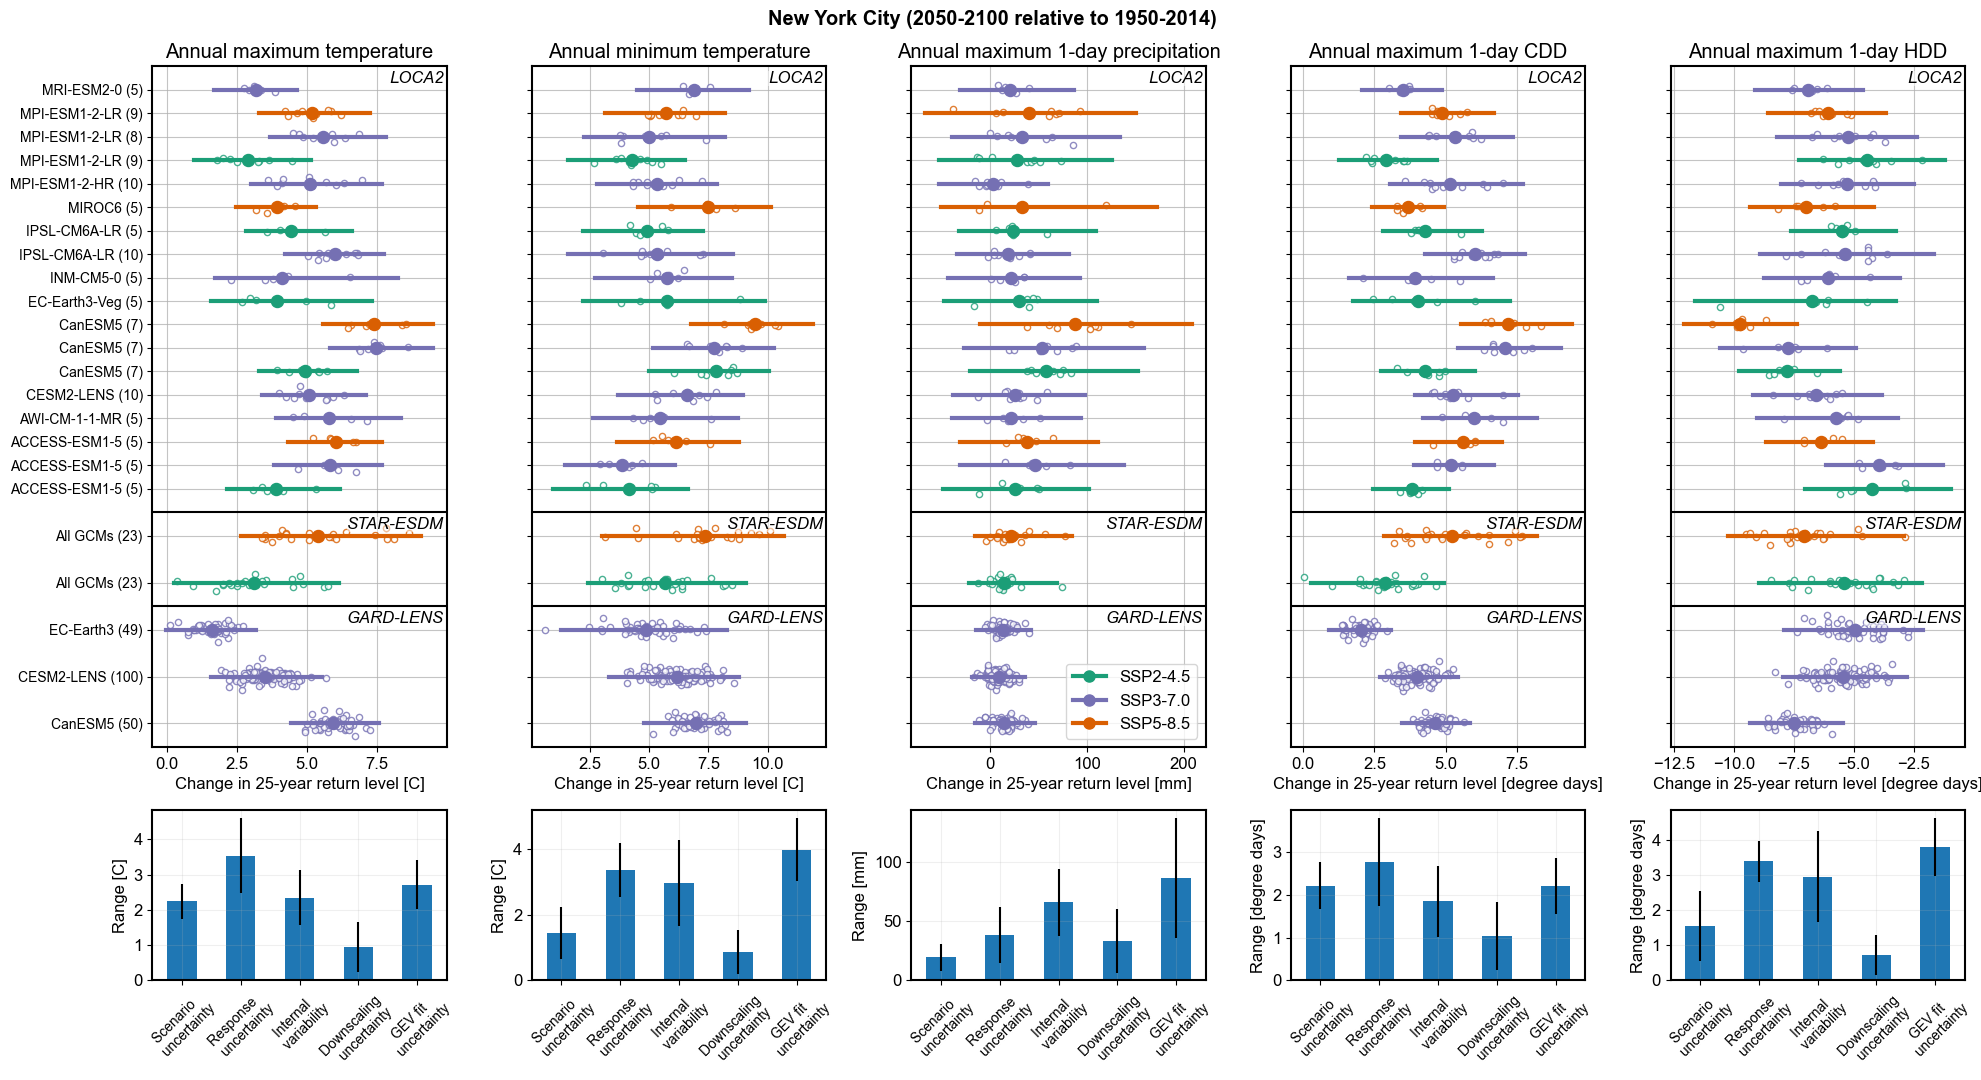

In [9]:
city = 'nyc'
plot_col = '25yr_return_level_diff'
hist_slice = '1950-2014'
proj_slice = '2050-2100'
fit_method = 'lmom'
stationary = 'stat'

metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr', 'max_cdd', 'max_hdd']

plot_city_metrics(city, metric_ids, plot_col, hist_slice, proj_slice, fit_method, stationary, legend=2)